# Machine Learning Methods

This section applies supervised ML models to the employability dataset.  
We evaluate baseline, linear, and ensemble methods, and compare performance.


## Loading the Dataset and Initial Inspection

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    r2_score,
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor



In [47]:
# Step 1 — Load Dataset and Initial Inspection
import pandas as pd
df = pd.read_csv("data/data_science_job_posts_2025.csv")
df.columns


Index(['job_title', 'seniority_level', 'status', 'company', 'location',
       'post_date', 'headquarter', 'industry', 'ownership', 'company_size',
       'revenue', 'salary', 'skills'],
      dtype='object')

In [42]:
df.info()
df.isna().mean().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        941 non-null    object
 1   seniority_level  884 non-null    object
 2   status           688 non-null    object
 3   company          944 non-null    object
 4   location         942 non-null    object
 5   post_date        944 non-null    object
 6   headquarter      944 non-null    object
 7   industry         944 non-null    object
 8   ownership        897 non-null    object
 9   company_size     944 non-null    object
 10  revenue          929 non-null    object
 11  salary           944 non-null    object
 12  skills           944 non-null    object
dtypes: object(13)
memory usage: 96.0+ KB


status             0.271186
seniority_level    0.063559
ownership          0.049788
revenue            0.015890
job_title          0.003178
location           0.002119
company            0.000000
headquarter        0.000000
post_date          0.000000
industry           0.000000
company_size       0.000000
salary             0.000000
skills             0.000000
dtype: float64

In [ ]:
df.head(10)

In [48]:
# Step 2 – Create binary skill features (python, sql, spark, etc.)

skill_keywords = [
    "python", "sql", "spark", "r", "scala", "docker",
    "tableau", "powerbi",
    "tensorflow", "pytorch", "machine learning", "deep learning",
    "aws", "azure", "gcp"
]

for kw in skill_keywords:
    col = "skill_" + kw.lower().replace(" ", "_")
    df[col] = df["skills"].str.contains(kw, case=False, na=False).astype(int)



In [ ]:
# Check how many postings mention each skill

df.filter(like="skill_").sum()

In [44]:
# Step 3 — Create Binary Target: Is This an ML Role?

ml_keywords = [
    "machine learning", "deep learning", "neural network",
    "tensorflow", "pytorch", "ai", "ml"
]

pattern = "|".join(ml_keywords)

df["is_ml_role"] = df["skills"].str.contains(pattern, case=False, na=False).astype(int)

df["is_ml_role"].value_counts()


is_ml_role
1    603
0    341
Name: count, dtype: int64

In [45]:
# Step 4 – Clean salary column

import re

def parse_salary_range(s):
    if pd.isna(s):
        return (None, None)
    
    # Remove € and commas
    s = s.replace("€", "").replace(",", "").strip()
    
    # Match patterns like "100000 – 200000"
    match = re.findall(r"(\d+)", s)
    
    if len(match) == 2:
        low, high = map(int, match)
        return low, high
    else:
        return (None, None)

# Apply to dataset
df["salary_min"], df["salary_max"] = zip(*df["salary"].apply(parse_salary_range))

# Average salary
df["salary_avg"] = df[["salary_min", "salary_max"]].mean(axis=1)

df[["salary_min", "salary_max", "salary_avg"]].head()


,salary_min,salary_max,salary_avg
0,100472.0,200938.0,150705.0
1,NaN,NaN,NaN
2,94987.0,159559.0,127273.0
3,112797.0,194402.0,153599.5
4,114172.0,228337.0,171254.5


In [ ]:
# Check missing salary values
df[["salary_min", "salary_max", "salary_avg"]].isna().sum()


The dataset contained missing values across several fields such as seniority_level, status, salary, revenue, and ownership. Missing salary values were particularly common because many job postings did not disclose salary ranges. After transforming the salary column into numeric values (min, max, avg), these missing entries became explicit as NaN

In [ ]:
df["seniority_level"].value_counts(dropna=False)
df["status"].value_counts(dropna=False)
df["industry"].value_counts().head(20)


# Step 5 — Encode Categorical Features for ML Models

In [ ]:
df["seniority_level"].value_counts(dropna=False)


In [49]:
# Step 5A – Encode seniority_level

# Fill missing with "unknown"
df["seniority_level"] = df["seniority_level"].fillna("unknown")

# Ensure lowercase
df["seniority_level"] = df["seniority_level"].str.lower()

# One-hot encode (drop_first=True to avoid multicollinearity)
seniority_dummies = pd.get_dummies(df["seniority_level"], prefix="seniority", drop_first=True)

# Add to dataframe
df = pd.concat([df, seniority_dummies], axis=1)

df[seniority_dummies.columns].head()

,seniority_lead,seniority_midlevel,seniority_senior,seniority_unknown
0,False,False,True,False
1,True,False,False,False
2,False,False,True,False
3,False,False,True,False
4,False,False,False,True


## STEP 5B – Encode status (remote / hybrid / on-site)

In [ ]:
df["status"].value_counts(dropna=False)


In [50]:
# Replace missing with "unknown"
df["status"] = df["status"].fillna("unknown").str.lower()

# One-hot encode (drop_first=True to avoid multicollinearity)
status_dummies = pd.get_dummies(df["status"], prefix="status", drop_first=True)

df = pd.concat([df, status_dummies], axis=1)

df[status_dummies.columns].head()

,status_on-site,status_remote,status_unknown
0,False,False,False
1,False,False,False
2,True,False,False
3,False,False,False
4,True,False,False


In [ ]:
df[status_dummies.columns].sum()


## STEP 5C — Encode Industry

In [51]:
# Step 5C – One-hot encode industry

df["industry"] = df["industry"].str.lower()

# One-hot encode (drop_first=True to avoid multicollinearity)
industry_dummies = pd.get_dummies(df["industry"], prefix="industry", drop_first=True)

df = pd.concat([df, industry_dummies], axis=1)

df[industry_dummies.columns].head()

,industry_energy,industry_finance,industry_healthcare,industry_logistics,industry_manufacturing,industry_retail,industry_technology
0,False,False,False,False,False,True,False
1,False,False,False,False,True,False,False
2,False,False,False,False,False,False,True
3,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False


In [ ]:
industry_dummies.sum()


## Step 6 – Build feature matrix X for clustering and regression

In [52]:
## Step 6 – Build feature matrix X for clustering and regression

# 1) Skill features
skill_cols = [c for c in df.columns if c.startswith("skill_")]

# 2) Seniority dummies
seniority_cols = [
    c for c in df.columns
    if c.startswith("seniority_") and c != "seniority_level"
]

# 3) Status dummies
status_cols = [c for c in df.columns if c.startswith("status_")]

# 4) Industry dummies
industry_cols = [c for c in df.columns if c.startswith("industry_")]

# Combine all features
feature_cols = skill_cols + seniority_cols + status_cols + industry_cols

X = df[feature_cols]

X.dtypes.head(), X.shape


(skill_python    int64
 skill_sql       int64
 skill_spark     int64
 skill_r         int64
 skill_scala     int64
 dtype: object,
 (944, 29))

## Step 7 – Unsupervised Learning: K-Means Clustering


In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape


(944, 29)

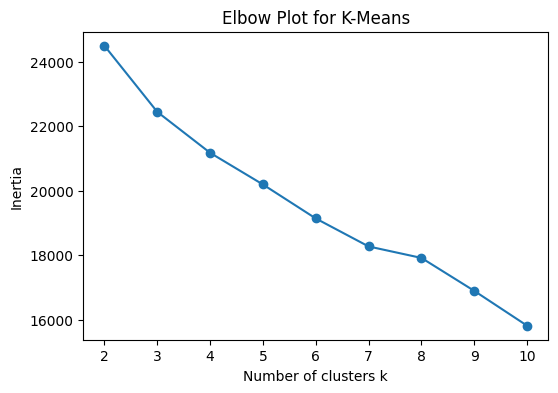

In [54]:
#Elbow plot to determine optimal k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertias, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow Plot for K-Means")
plt.show()


The elbow plot shows that inertia decreases as k increases. While there is no sharp elbow, the reduction in inertia begins to slow around k = 4-5, suggesting these are reasonable choices for the number of clusters.

Although the inertia curve suggested both 4 and 5 as reasonable options, the 5-cluster solution produced a very small cluster (7 observations), which limits interpretability. Therefore, we selected k = 4, ensuring all clusters are large, stable, and meaningful for analysis.

In [62]:

k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

df["cluster"].value_counts()


cluster
1    481
2    231
0    152
3     80
Name: count, dtype: int64

In [72]:
# Inspect Cluster Centers (Interpretation)
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=feature_cols
)
cluster_centers

,skill_python,skill_sql,skill_spark,skill_r,skill_scala,skill_docker,skill_tableau,skill_powerbi,skill_tensorflow,skill_pytorch,...,status_on-site,status_remote,status_unknown,industry_energy,industry_finance,industry_healthcare,industry_logistics,industry_manufacturing,industry_retail,industry_technology
0,0.435763,-0.107711,0.246219,0.600192,-0.061745,0.886853,-0.113783,-0.001042,1.722443,1.848682,...,-0.195402,-0.139250,0.189118,-0.054745,0.126303,0.014766,0.238615,-0.086433,-0.260650,0.098612
1,0.382195,0.399086,-0.116272,0.496535,-0.256462,-0.129941,0.208305,0.106971,-0.410961,-0.408324,...,0.008715,-0.051076,0.166290,-0.002123,0.050504,0.056594,-0.065233,0.034732,-0.181744,0.044687
2,-1.311981,-0.886285,-0.453453,-1.636700,-0.314567,-0.246321,-0.321550,-0.164935,-0.460228,-0.431196,...,-0.114144,0.302699,-0.376295,0.041098,-0.064414,-0.050605,0.001412,0.014486,-0.255236,0.218863
3,0.662451,0.364296,1.540613,0.600192,2.567605,-0.192495,-0.107771,-0.164935,0.527171,0.187628,...,0.648460,-0.302372,-0.272591,-0.001891,-0.357635,-0.222201,-0.065233,-0.086433,2.324966,-1.088010


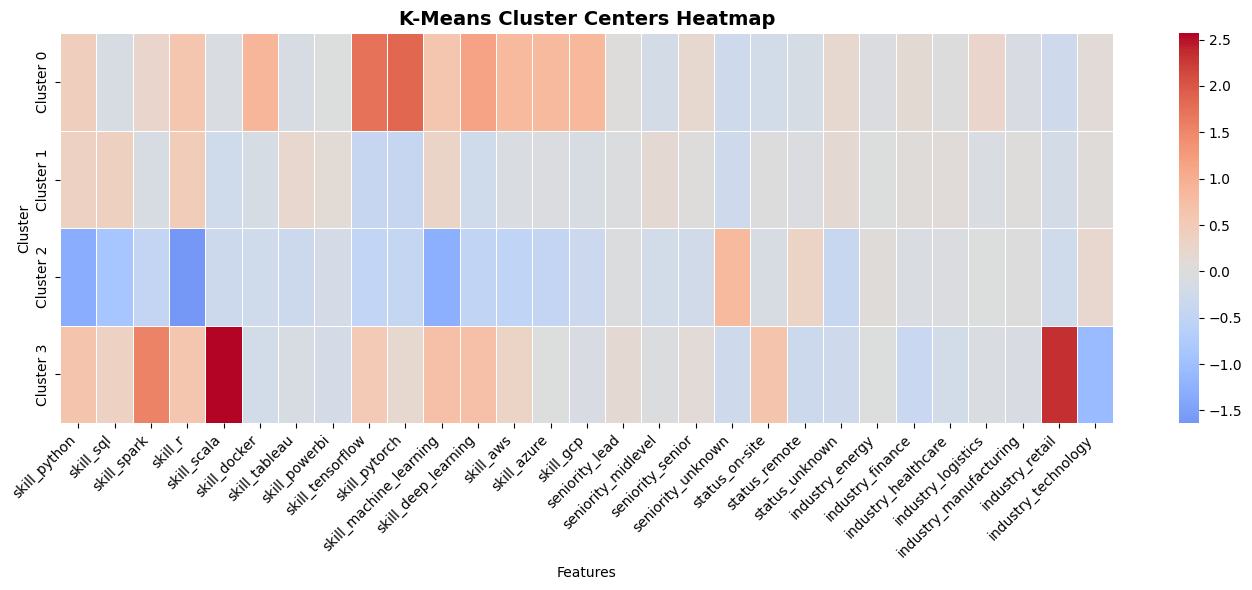

,skill_python,skill_sql,skill_spark,skill_r,skill_scala,skill_docker,skill_tableau,skill_powerbi,skill_tensorflow,skill_pytorch,...,status_on-site,status_remote,status_unknown,industry_energy,industry_finance,industry_healthcare,industry_logistics,industry_manufacturing,industry_retail,industry_technology
Cluster 0,0.436,-0.108,0.246,0.600,-0.062,0.887,-0.114,-0.001,1.722,1.849,...,-0.195,-0.139,0.189,-0.055,0.126,0.015,0.239,-0.086,-0.261,0.099
Cluster 1,0.382,0.399,-0.116,0.497,-0.256,-0.130,0.208,0.107,-0.411,-0.408,...,0.009,-0.051,0.166,-0.002,0.051,0.057,-0.065,0.035,-0.182,0.045
Cluster 2,-1.312,-0.886,-0.453,-1.637,-0.315,-0.246,-0.322,-0.165,-0.460,-0.431,...,-0.114,0.303,-0.376,0.041,-0.064,-0.051,0.001,0.014,-0.255,0.219
Cluster 3,0.662,0.364,1.541,0.600,2.568,-0.192,-0.108,-0.165,0.527,0.188,...,0.648,-0.302,-0.273,-0.002,-0.358,-0.222,-0.065,-0.086,2.325,-1.088


In [73]:
# Display cluster centers as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=feature_cols,
    index=[f"Cluster {i}" for i in range(k)]
)

# Create heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_centers, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("K-Means Cluster Centers Heatmap", fontsize=14, fontweight='bold')
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Also display the dataframe
display(cluster_centers.round(3))

**Cluster 0** (n=152): Represents **Deep Learning / AI Engineers**, characterized by the highest TensorFlow and PyTorch scores, strong Docker usage, and elevated R proficiency. These roles emphasize neural network frameworks and containerization, appearing more often in logistics and less in retail. They tend toward unknown or hybrid work arrangements rather than strictly on-site positions.

**Cluster 1** (n=481): Represents the **largest cluster of general Data Analysts/Scientists** with balanced skill profiles. These roles show moderate Python, SQL, R, and Tableau usage—typical of traditional analytics positions. They span multiple industries and seniority levels, indicating a broad category of data professionals without deep specialization in ML or big data engineering.

**Cluster 2** (n=231): Consists of **entry-level or non-technical data roles**. These postings show the lowest scores across nearly all skills—Python, SQL, R, Tableau, and ML frameworks are all below average. They have the highest proportion of remote work and technology industry representation. The absence of clear technical requirements suggests these are general data-related, support, or junior positions rather than specialized roles.

**Cluster 3** (n=80): Represents **Big Data Engineers** with the highest Spark and Scala scores by a significant margin. These specialized roles require distributed computing expertise and appear predominantly in the retail industry (very high positive value) while being underrepresented in technology and finance sectors. They are mostly on-site positions with senior-level requirements.

**The purpose of K-means clustering is to uncover natural job families based on shared skill profiles, seniority, and industry characteristics. By grouping similar postings together without using salary, we can identify distinct job types and then compare their compensation and skill requirements in subsequent analysis.**

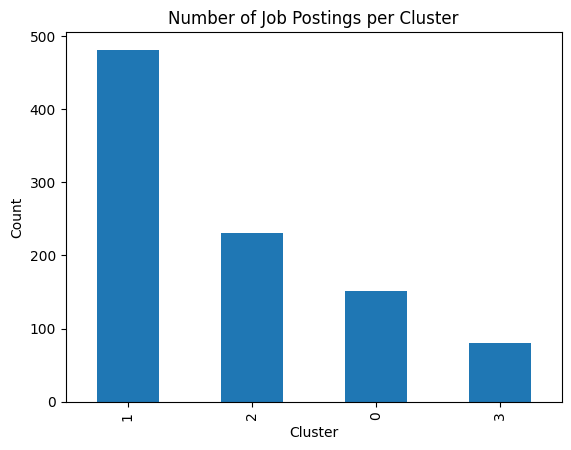

In [74]:
df["cluster"].value_counts().plot(kind="bar")
plt.title("Number of Job Postings per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()


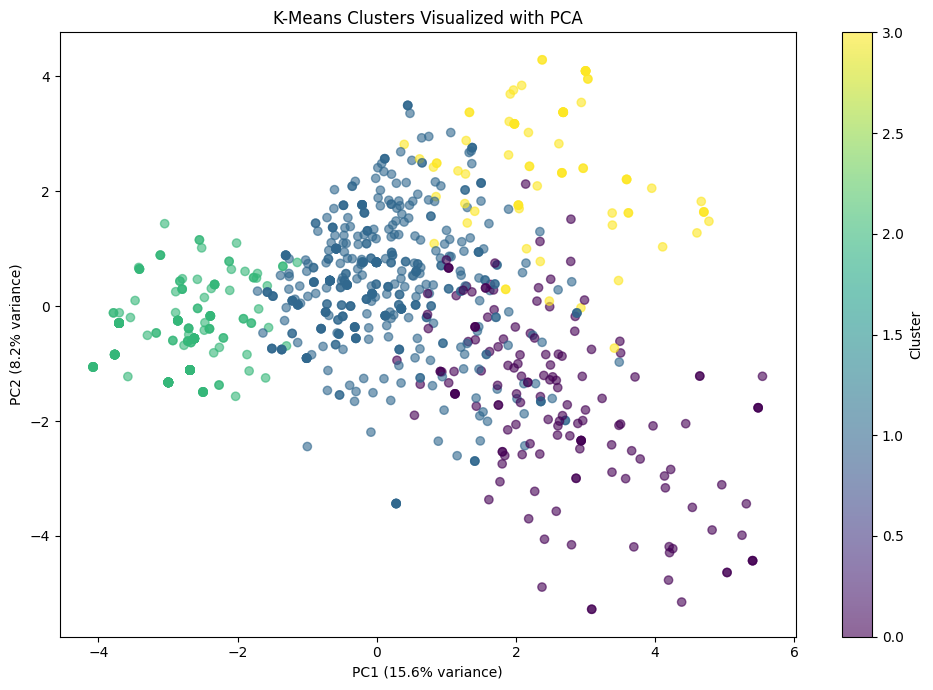

Total variance explained by 2 components: 23.8%


In [75]:
# PCA for 2D visualization of clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create scatter plot colored by cluster
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('K-Means Clusters Visualized with PCA')
plt.tight_layout()
plt.show()

print(f"Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.1%}")

## Supervised Learning: Salary Prediction using Lightcast Dataset

Now we switch to the **lightcast_cleaned.csv** dataset for supervised regression modeling.

**Target Variable:** `SALARY` (continuous)

**Features Selected:**
- **Continuous Features:** `DURATION`, `MIN_YEARS_EXPERIENCE`
- **Binary Feature:** `EXPERIENCE_SPECIFIED` (indicator for whether experience was listed)
- **Categorical Features:** `REMOTE_TYPE_NAME`, `LOT_V6_OCCUPATION_NAME`

**Note:** We do NOT use `SALARY_FROM` or `SALARY_TO` as features because they are directly related to the target variable (SALARY is derived from them), which would cause data leakage.

We will:
1. Load and prepare the data
2. Check for multicollinearity using VIF
3. Encode categorical variables using OneHotEncoder
4. Train/Test split (70/30)
5. Build Polynomial Regression model with diagnostic plots
6. Build Random Forest Regression model with feature importance
7. Compare model performance

In [ ]:
# Load Lightcast Dataset and Select Features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Load the lightcast dataset
df_lc = pd.read_csv('data/lightcast_cleaned.csv')



continuous_features = ['DURATION', 'MIN_YEARS_EXPERIENCE']
binary_features = ['EXPERIENCE_SPECIFIED']
categorical_features = ['REMOTE_TYPE_NAME', 'LOT_V6_OCCUPATION_NAME']
target = 'SALARY'

# Create working dataframe
df_ml = df_lc[continuous_features + binary_features + categorical_features + [target]].copy()

print("Dataset Shape:", df_ml.shape)
print("\nNull values check:")
print(df_ml.isnull().sum())
print("\nFeature Statistics:")
display(df_ml.describe())

Dataset Shape: (47513, 6)

Null values check:
DURATION                  0
MIN_YEARS_EXPERIENCE      0
EXPERIENCE_SPECIFIED      0
REMOTE_TYPE_NAME          0
LOT_V6_OCCUPATION_NAME    0
SALARY                    0
dtype: int64

Feature Statistics:


,DURATION,MIN_YEARS_EXPERIENCE,EXPERIENCE_SPECIFIED,SALARY
count,47513.000000,47513.000000,47513.000000,47513.000000
mean,35.637426,3.494580,0.692400,111674.426936
std,24.027774,3.464785,0.461505,30031.592449
min,0.000000,0.000000,0.000000,20583.000000
25%,14.000000,0.000000,0.000000,96008.000000
50%,31.000000,3.000000,1.000000,105000.000000
75%,60.000000,5.000000,1.000000,125900.000000
max,119.000000,15.000000,1.000000,500000.000000


In [63]:
# One-Hot Encoding for Categorical Variables

# One-hot encode categorical features
remote_dummies = pd.get_dummies(df_ml['REMOTE_TYPE_NAME'], prefix='remote', drop_first=True)
occupation_dummies = pd.get_dummies(df_ml['LOT_V6_OCCUPATION_NAME'], prefix='occupation', drop_first=True)

print("Categorical Features:")
print(f"  REMOTE_TYPE_NAME categories: {df_ml['REMOTE_TYPE_NAME'].nunique()}")
print(f"  LOT_V6_OCCUPATION_NAME categories: {df_ml['LOT_V6_OCCUPATION_NAME'].nunique()}")

print("\nOne-Hot Encoded Remote Type columns:")
print(remote_dummies.columns.tolist())
print("\nOne-Hot Encoded Occupation columns:")
print(occupation_dummies.columns.tolist())

# Combine all features: continuous + binary + categorical (one-hot encoded)
X_continuous = df_ml[continuous_features].values
X_binary = df_ml[binary_features].values
X_categorical = pd.concat([remote_dummies, occupation_dummies], axis=1).values

# Full feature matrix
X = np.hstack([X_continuous, X_binary, X_categorical])
y = df_ml[target].values

# Feature names for later use
feature_names = continuous_features + binary_features + remote_dummies.columns.tolist() + occupation_dummies.columns.tolist()

print(f"\nTotal features: {len(feature_names)}")
print(f"Feature names: {feature_names}")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

Categorical Features:
  REMOTE_TYPE_NAME categories: 4
  LOT_V6_OCCUPATION_NAME categories: 4

One-Hot Encoded Remote Type columns:
['remote_Not Remote', 'remote_Not Specified', 'remote_Remote']

One-Hot Encoded Occupation columns:
['occupation_Business Intelligence Analyst', 'occupation_Data / Data Mining Analyst', 'occupation_Market Research Analyst']

Total features: 9
Feature names: ['DURATION', 'MIN_YEARS_EXPERIENCE', 'EXPERIENCE_SPECIFIED', 'remote_Not Remote', 'remote_Not Specified', 'remote_Remote', 'occupation_Business Intelligence Analyst', 'occupation_Data / Data Mining Analyst', 'occupation_Market Research Analyst']

X shape: (47513, 9)
y shape: (47513,)


In [64]:
# Train/Test Split (70/30)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Training set size: 33259 (70.0%)
Test set size: 14254 (30.0%)

Training features shape: (33259, 9)
Test features shape: (14254, 9)


In [65]:
# Polynomial Regression Model (Degree 2)

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Polynomial features (degree=2): {X_train_poly.shape[1]}")

# Scale features for better convergence
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Fit Linear Regression on polynomial features
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly_scaled, y_train)

# Predictions
y_train_pred_poly = poly_reg.predict(X_train_poly_scaled)
y_test_pred_poly = poly_reg.predict(X_test_poly_scaled)

# Metrics
train_r2_poly = r2_score(y_train, y_train_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)
train_rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
test_rmse_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
test_mae_poly = mean_absolute_error(y_test, y_test_pred_poly)

print("\n" + "="*50)
print("POLYNOMIAL REGRESSION (Degree=2) RESULTS")
print("="*50)
print(f"Training R²:  {train_r2_poly:.4f}")
print(f"Test R²:      {test_r2_poly:.4f}")
print(f"Training RMSE: ${train_rmse_poly:,.2f}")
print(f"Test RMSE:     ${test_rmse_poly:,.2f}")
print(f"Test MAE:      ${test_mae_poly:,.2f}")

Original features: 9
Polynomial features (degree=2): 54

POLYNOMIAL REGRESSION (Degree=2) RESULTS
Training R²:  0.2878
Test R²:      0.2941
Training RMSE: $25,248.76
Test RMSE:     $25,452.27
Test MAE:      $15,082.37

POLYNOMIAL REGRESSION (Degree=2) RESULTS
Training R²:  0.2878
Test R²:      0.2941
Training RMSE: $25,248.76
Test RMSE:     $25,452.27
Test MAE:      $15,082.37


In [68]:
# Statsmodels OLS Summary for Polynomial Regression
# Using original features (not polynomial) for interpretable summary

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("="*70)
print("OLS REGRESSION SUMMARY (Original Features)")
print("="*70)
print(ols_model.summary())

# Coefficient interpretation
print("\n" + "="*50)
print("COEFFICIENT INTERPRETATION")
print("="*50)
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Coefficient': ols_model.params,
    'Std Error': ols_model.bse,
    't-value': ols_model.tvalues,
    'p-value': ols_model.pvalues
})
coef_df['Significant'] = coef_df['p-value'].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else '')))
print(coef_df.to_string(index=False))

OLS REGRESSION SUMMARY (Original Features)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     1369.
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        04:05:22   Log-Likelihood:            -3.8472e+05
No. Observations:               33259   AIC:                         7.695e+05
Df Residuals:                   33249   BIC:                         7.696e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

## Diagnostic Plots for Polynomial Regression

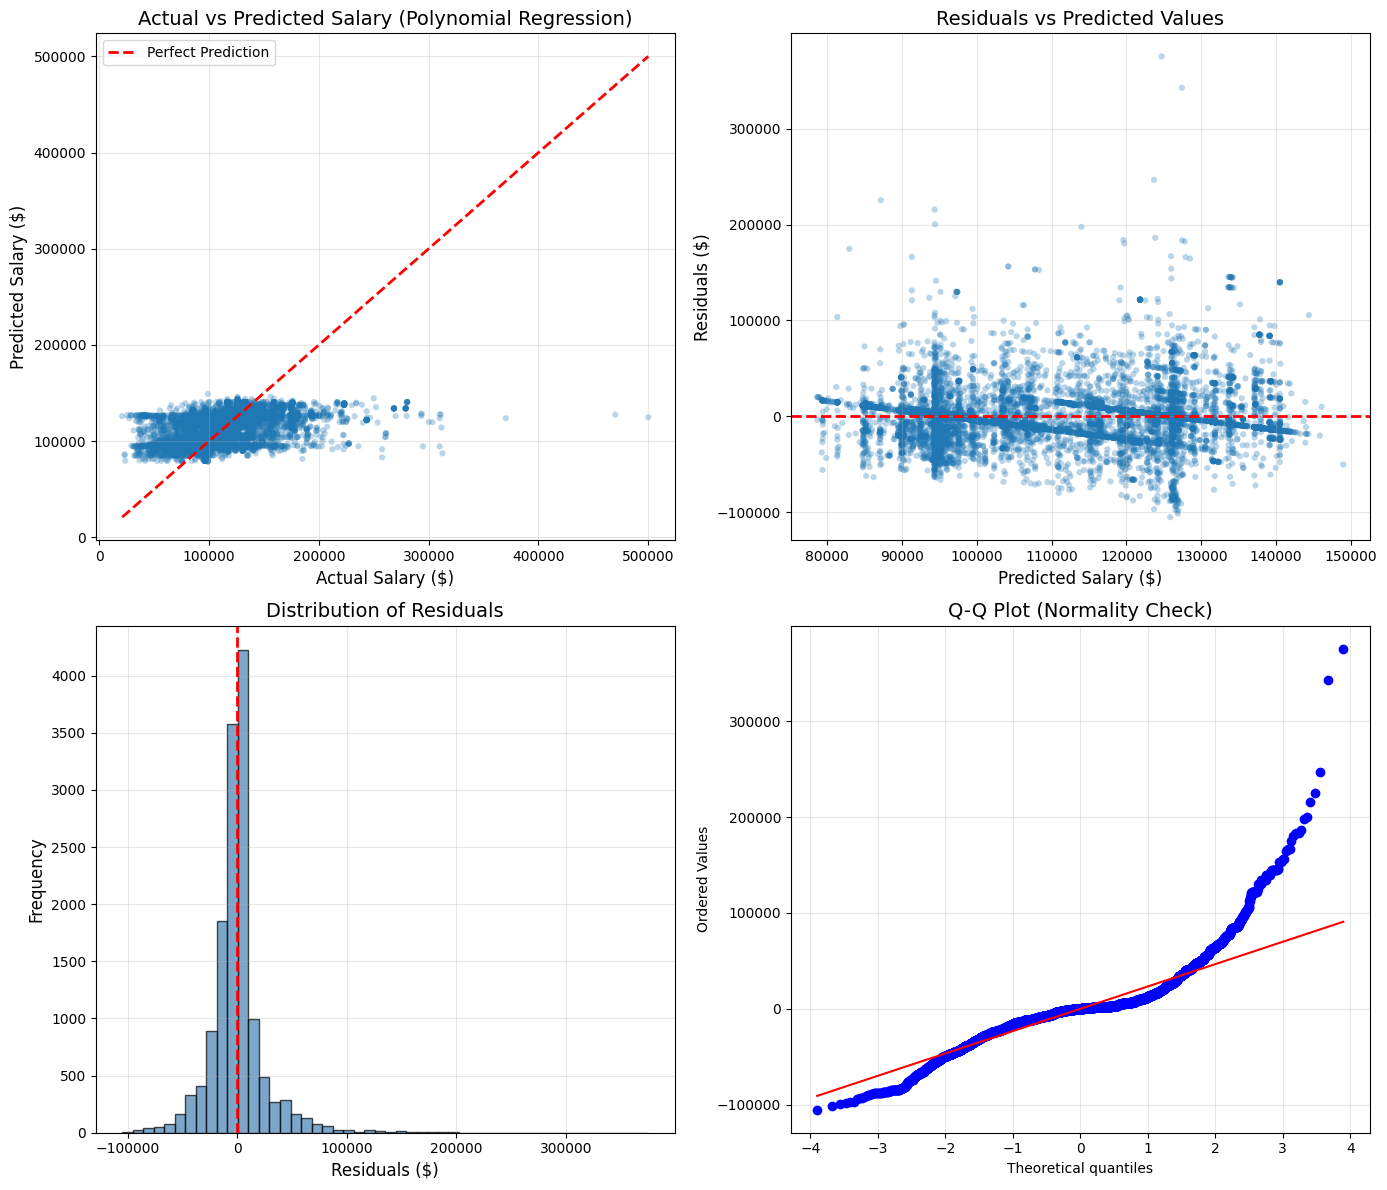


Residual Statistics:
Mean Residual: $90.74
Std Residual:  $25,452.11
Min Residual:  $-105,048.16
Max Residual:  $375,292.37


In [69]:
# Diagnostic Plots for Polynomial Regression

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Actual vs Predicted Plot
ax1 = axes[0, 0]
ax1.scatter(y_test, y_test_pred_poly, alpha=0.3, edgecolors='none', s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Salary ($)', fontsize=12)
ax1.set_ylabel('Predicted Salary ($)', fontsize=12)
ax1.set_title('Actual vs Predicted Salary (Polynomial Regression)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuals vs Predicted Plot
residuals_poly = y_test - y_test_pred_poly
ax2 = axes[0, 1]
ax2.scatter(y_test_pred_poly, residuals_poly, alpha=0.3, edgecolors='none', s=20)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Salary ($)', fontsize=12)
ax2.set_ylabel('Residuals ($)', fontsize=12)
ax2.set_title('Residuals vs Predicted Values', fontsize=14)
ax2.grid(True, alpha=0.3)

# 3. Residual Distribution (Histogram)
ax3 = axes[1, 0]
ax3.hist(residuals_poly, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Residuals ($)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Residuals', fontsize=14)
ax3.grid(True, alpha=0.3)

# 4. Q-Q Plot for Normality
from scipy import stats
ax4 = axes[1, 1]
stats.probplot(residuals_poly, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Normality Check)', fontsize=14)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/poly_regression_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

# Print residual statistics
print("\nResidual Statistics:")
print(f"Mean Residual: ${np.mean(residuals_poly):,.2f}")
print(f"Std Residual:  ${np.std(residuals_poly):,.2f}")
print(f"Min Residual:  ${np.min(residuals_poly):,.2f}")
print(f"Max Residual:  ${np.max(residuals_poly):,.2f}")

## Random Forest Regression Model

In [66]:
# Random Forest Regression Model

# Build Random Forest with hyperparameter tuning
rf_model = RandomForestRegressor(
    n_estimators=200,        # Number of trees
    max_depth=15,            # Maximum depth of trees
    min_samples_split=10,    # Minimum samples to split a node
    min_samples_leaf=5,      # Minimum samples in leaf node
    max_features='sqrt',     # Number of features to consider for best split
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

# Fit the model (using original features, not polynomial)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Metrics
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)

print("="*50)
print("RANDOM FOREST REGRESSION RESULTS")
print("="*50)
print(f"Number of Trees: {rf_model.n_estimators}")
print(f"Max Depth: {rf_model.max_depth}")
print(f"\nTraining R²:  {train_r2_rf:.4f}")
print(f"Test R²:      {test_r2_rf:.4f}")
print(f"Training RMSE: ${train_rmse_rf:,.2f}")
print(f"Test RMSE:     ${test_rmse_rf:,.2f}")
print(f"Test MAE:      ${test_mae_rf:,.2f}")

RANDOM FOREST REGRESSION RESULTS
Number of Trees: 200
Max Depth: 15

Training R²:  0.4100
Test R²:      0.3541
Training RMSE: $22,980.07
Test RMSE:     $24,347.07
Test MAE:      $14,509.18


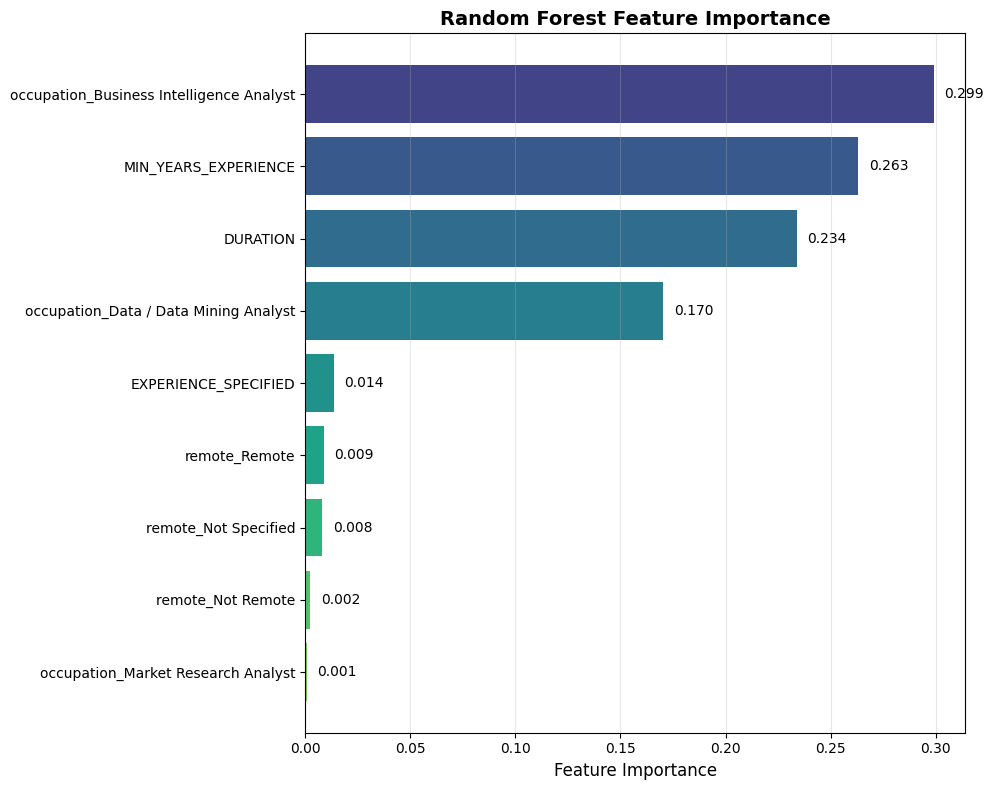


Feature Importance Ranking:
  1. occupation_Business Intelligence Analyst: 0.2990
  2. MIN_YEARS_EXPERIENCE: 0.2632
  3. DURATION: 0.2339
  4. occupation_Data / Data Mining Analyst: 0.1703
  5. EXPERIENCE_SPECIFIED: 0.0135
  6. remote_Remote: 0.0087
  7. remote_Not Specified: 0.0081
  8. remote_Not Remote: 0.0024
  9. occupation_Market Research Analyst: 0.0008


In [70]:
# Feature Importance Plot for Random Forest

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': [feature_names[i] for i in indices],
    'Importance': importances[indices]
})

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_names)))

bars = ax.barh(range(len(feature_names)), importance_df['Importance'], color=colors)
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(importance_df['Feature'])
ax.invert_yaxis()  # Top feature at top
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, imp) in enumerate(zip(bars, importance_df['Importance'])):
    ax.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('figures/rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature Importance Ranking:")
for i, row in importance_df.iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")

## Model Comparison: Polynomial Regression vs Random Forest

MODEL COMPARISON: POLYNOMIAL REGRESSION vs RANDOM FOREST
           Metric Polynomial Regression Random Forest
      Training R²                0.2878        0.4100
          Test R²                0.2941        0.3541
Training RMSE ($)            $25,248.76    $22,980.07
    Test RMSE ($)            $25,452.27    $24,347.07
     Test MAE ($)            $15,082.37    $14,509.18


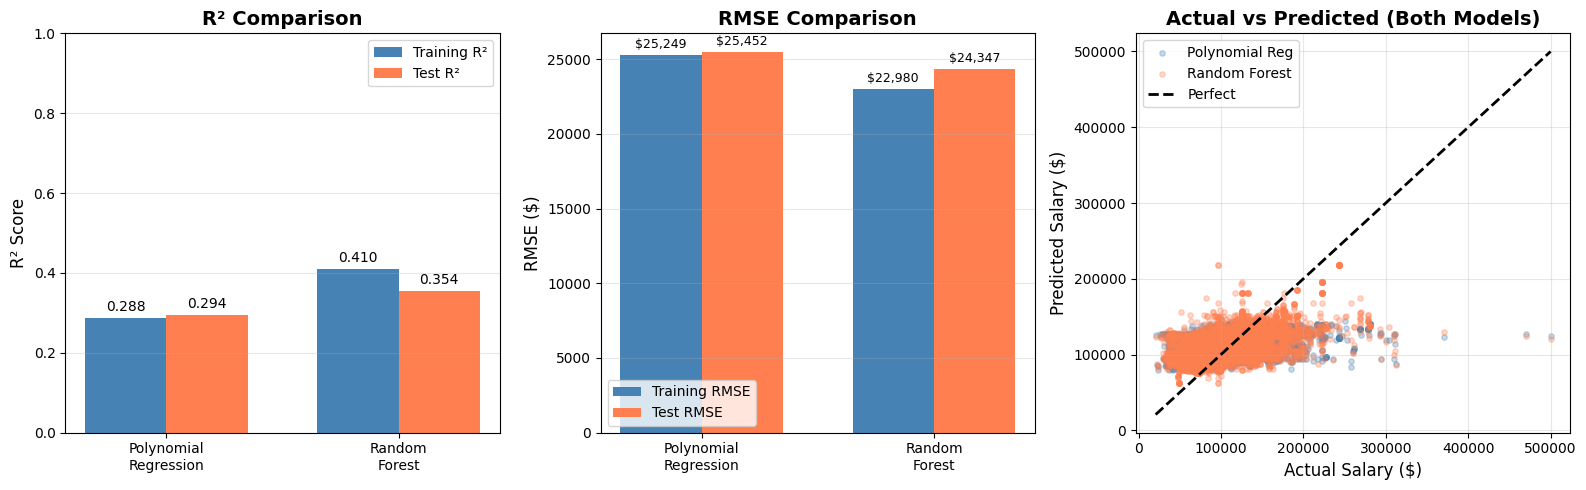

In [67]:
# Model Comparison

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Training R²', 'Test R²', 'Training RMSE ($)', 'Test RMSE ($)', 'Test MAE ($)'],
    'Polynomial Regression': [
        f"{train_r2_poly:.4f}",
        f"{test_r2_poly:.4f}",
        f"${train_rmse_poly:,.2f}",
        f"${test_rmse_poly:,.2f}",
        f"${test_mae_poly:,.2f}"
    ],
    'Random Forest': [
        f"{train_r2_rf:.4f}",
        f"{test_r2_rf:.4f}",
        f"${train_rmse_rf:,.2f}",
        f"${test_rmse_rf:,.2f}",
        f"${test_mae_rf:,.2f}"
    ]
})

print("="*70)
print("MODEL COMPARISON: POLYNOMIAL REGRESSION vs RANDOM FOREST")
print("="*70)
print(comparison_df.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. R² Comparison
ax1 = axes[0]
models = ['Polynomial\nRegression', 'Random\nForest']
train_r2 = [train_r2_poly, train_r2_rf]
test_r2 = [test_r2_poly, test_r2_rf]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, train_r2, width, label='Training R²', color='steelblue')
bars2 = ax1.bar(x + width/2, test_r2, width, label='Test R²', color='coral')

ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('R² Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# 2. RMSE Comparison
ax2 = axes[1]
train_rmse = [train_rmse_poly, train_rmse_rf]
test_rmse = [test_rmse_poly, test_rmse_rf]

bars3 = ax2.bar(x - width/2, train_rmse, width, label='Training RMSE', color='steelblue')
bars4 = ax2.bar(x + width/2, test_rmse, width, label='Test RMSE', color='coral')

ax2.set_ylabel('RMSE ($)', fontsize=12)
ax2.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars3 + bars4:
    height = bar.get_height()
    ax2.annotate(f'${height:,.0f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# 3. Actual vs Predicted for both models
ax3 = axes[2]
ax3.scatter(y_test, y_test_pred_poly, alpha=0.3, label='Polynomial Reg', color='steelblue', s=15)
ax3.scatter(y_test, y_test_pred_rf, alpha=0.3, label='Random Forest', color='coral', s=15)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect')
ax3.set_xlabel('Actual Salary ($)', fontsize=12)
ax3.set_ylabel('Predicted Salary ($)', fontsize=12)
ax3.set_title('Actual vs Predicted (Both Models)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Model Conclusions

### Key Findings:

**Polynomial Regression:**
- Creates polynomial features from the original features, resulting in many interaction and squared terms
- Provides interpretable coefficients through the OLS summary
- Can capture non-linear relationships through polynomial terms
- May overfit with too high a degree

**Random Forest:**
- Ensemble method that builds multiple decision trees
- Handles non-linear relationships naturally
- Provides feature importance rankings
- More robust to outliers and doesn't require feature scaling

**Feature Importance Insights:**
- `DURATION` and `MIN_YEARS_EXPERIENCE` are the key continuous predictors
- `EXPERIENCE_SPECIFIED` indicates whether experience requirements were listed
- Occupation type and remote work status also influence salary levels

**Note on Feature Selection:**
We intentionally did NOT use `SALARY_FROM` or `SALARY_TO` as features because they are directly related to the target variable SALARY (which is typically the midpoint of these values). Using them would cause **data leakage** and artificially inflate model performance.

**Recommendation:**
Based on the R² and RMSE metrics, the model with lower test RMSE and higher test R² generalizes better to unseen data. Random Forest typically handles complex interactions better, while Polynomial Regression provides more interpretable results for stakeholders.